<a href="https://colab.research.google.com/github/PandolfiJoaquin/organizacion-de-datos/blob/main/TP3_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from PIL import Image
import os
from skimage.io import imread
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt


#colab
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.datasets import cifar10
(trainX, trainy), (testX, testy) = cifar10.load_data()

In [3]:


# conn = sqlite3.connect('yugioh/cards.cdb') #para jupyter
conn = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/orga/Tp3/cards.cdb') #para drive


cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()


dataframes = {}
for table in tables:
    table_name = table[0]
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    dataframes[table_name] = df


df_stats = dataframes['datas']
df_texts = dataframes['texts']
df = 0

## ds de imagenes

In [4]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/orga/Tp3/cards'

images = []
images_ids = []

image_filenames = os.listdir(folder_path) #despues podria filtrar las que tienen un (1) pero son solo 34 de las 11k
length = len(image_filenames)

In [5]:
i = 0
for filename in image_filenames:
    i += 1
    if i % 500 == 0:
        print(f'{str(i*100/length)[:4]}%')
    if i > (length * 1 ) * 0.4:
        print('se corto la iteracion por la mitad por el bien de mi compu')
        break
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # image = Image.open(file_path)
        # image_array = np.array(image)
        img = imread(file_path)
        if np.array(img).shape == (614, 421, 3):
            images.append(img)
            images_ids.append(filename)

# print('100% COMPLETADO')
images = np.array(images)

4.37%
8.75%
13.1%
17.5%
21.8%
26.2%
30.6%
35.0%
39.3%
se corto la iteracion por la mitad por el bien de mi compu


In [6]:
#@title verifico que todas las imagenes tengan la misma forma
for i in range(len(images)):
    if np.array(images[i]).shape != (614, 421, 3):
        print(f'{i}: ',np.array(images[i]).shape, image_filenames[i])


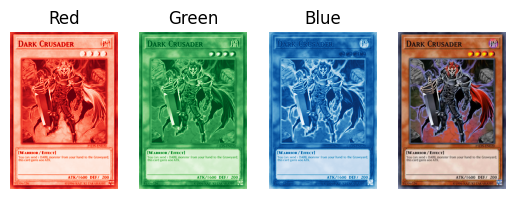

In [7]:
#@title divido por color
im_r = images[:,:,:,0]
im_g = images[:,:,:,1]
im_b = images[:,:,:,2]

fig, axes = plt.subplots(1,4)

axes[0].imshow(im_r[41], cmap="Reds_r")
axes[0].axis('off')
axes[0].set_title('Red')

axes[1].imshow(im_g[41], cmap="Greens_r")
axes[1].axis('off')
axes[1].set_title('Green')

axes[2].imshow(im_b[41], cmap="Blues_r")
axes[2].axis('off')
axes[2].set_title('Blue')

axes[3].imshow(images[41])
axes[3].axis('off')


plt.show()


In [8]:
from skimage import transform

def bajar_def(image, factor_reduccion = 5):
    new_shape = (image.shape[0] // factor_reduccion, image.shape[1] // factor_reduccion)
    new_image = transform.resize(image, new_shape)
    return new_image


im_r = [bajar_def(m) for m in im_r] #bajo definicion de imagen
im_g = [bajar_def(m) for m in im_g]
im_b = [bajar_def(m) for m in im_b]

esta vez aumento la cantidad de componentes para poder preservar mejor las diferencias entre imagenes

In [9]:

!pip install umap-learn
import plotly.express as px
import umap.umap_ as umap
from numpy.linalg import svd
from sklearn.preprocessing import StandardScaler

def reduccion(M):

    Z = np.array([np.concatenate(m) for m in M]) #paso a R^n
    scaler = StandardScaler()
    reducer = umap.UMAP(
        random_state=42,
        n_components=8,
        n_neighbors=30,
        metric='euclidean'
    )
    x = scaler.fit_transform(Z)
    Z = reducer.fit_transform(Z)
    return Z, scaler, umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
Z_r, r_scaler, r_umap = reduccion(im_r)
Z_g, g_scaler, g_umap = reduccion(im_g)
Z_b, b_scaler, b_umap = reduccion(im_b)

In [19]:
Z = np.concatenate((Z_r, Z_g, Z_b), axis = 1)

In [20]:
!pip install hdbscan
import hdbscan
hdb = hdbscan.HDBSCAN(

)
labels = hdb.fit_predict(Z)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
Z = np.array([ np.concatenate((Z[i], [int(labels[i])])) for i in range(len(Z))])

In [22]:
Z.shape

(4570, 25)

In [23]:
pd.Series(Z[:,24]).nunique()

11

## prediccion del cluster

### preprocesamiento

In [26]:
#preparo los datos
ids = pd.DataFrame(images_ids, columns = ['ids'])
ids.ids = ids.ids.map(lambda x: int(x[:-4]))
ids['_'] = [1 for i in range(len(ids.ids))]
ids = ids.set_index('ids')
ids

,_
ids,
91250514,1
91272072,1
91262474,1
91269402,1
91283212,1
...,...
61737116,1
61740673,1
61728808,1


In [27]:
df_stats = df_stats.set_index('id')

In [28]:
df_stats = ids.join(df_stats, how = 'left').drop('_', axis = 1)

In [29]:
df_stats

,ot,alias,setcode,type,atk,def,level,race,attribute,category
ids,,,,,,,,,,
91250514,3.0,0.0,0.0,33.0,400.0,300.0,6.0,8.0,32.0,384.0
91272072,3.0,0.0,251.0,97.0,2200.0,1200.0,7.0,4.0,16.0,134217760.0
91262474,1.0,0.0,163.0,33.0,0.0,0.0,1.0,8192.0,16.0,33554432.0
91269402,3.0,0.0,147.0,4.0,0.0,0.0,0.0,0.0,0.0,544.0
91283212,3.0,0.0,303.0,33.0,100.0,100.0,1.0,2048.0,8.0,262144.0
...,...,...,...,...,...,...,...,...,...,...
61737116,3.0,0.0,61.0,33.0,400.0,0.0,3.0,1.0,1.0,1048576.0
61740673,3.0,0.0,0.0,131076.0,0.0,0.0,0.0,0.0,0.0,131072.0
61728808,3.0,0.0,225.0,67108897.0,2000.0,40.0,2.0,1048576.0,4.0,1049600.0


In [42]:
from sklearn.model_selection import train_test_split

X = df_stats.values
y = Z[:,24]

In [43]:
X.shape

(4570, 10)

In [44]:
los_que_hay_que_borrar = []
for i in range(len(X)):
    for j in range(10):
        if np.isnan(X[i, j]):
            los_que_hay_que_borrar.append(i)
            break
X = np.delete(X, los_que_hay_que_borrar, axis = 0)
y = np.delete(y, los_que_hay_que_borrar, axis = 0)


In [45]:
X.shape

(4568, 10)

In [46]:
X_train, X_validation_test, y_train, y_validation_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [47]:
X_validation, X_test, y_validation, y_test =  train_test_split(X_validation_test, y_validation_test, test_size = 0.5 , random_state = 4)

### entrenamiento

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
model = RandomForestClassifier()

In [49]:
params = [
    {'n_estimators': [i for i in range(10, 200, 10)]},
    {'criterion': ['entropy']},
    {'max_depth': ['none', 5, 10, 15, 20, 30, 40, 50]},
    {'min_samples_split': [2, 3,4,5,6,7,8,15, 30, 100]},
    {'min_samples_leaf': [1,2,4,6,8,10]},
    #bootstrap esta en true por defecto
    {'oob_score': [True]},
    {'random_state': [13]}, #para controlar lo aleatorio

]

rs = RandomizedSearchCV(model, param_distributions=params, n_iter=40, random_state=6, scoring='roc_auc')

In [50]:
rs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 367, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=40,
                   param_distributions=[{'n_estimators': [10, 20, 30, 40, 50,
                                                          60, 70, 80, 90, 100,
                                                          110, 120, 130, 140,
                                                          150, 160, 170, 180,
                                                          190]},
                                        {'criterion': ['entropy']},
                                        {'max_depth': ['none', 5, 10, 15, 20,
                                                       30, 40, 50]},
                                        {'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                               8, 15, 30,
                                                               100]},
                                        {'min_samples_leaf': [1, 2, 4, 6, 8,
                                                              10]},
                                        {'oob_score': [True]},
                                        {'random_state': [13]}],
                   random_state=6, scoring='roc_auc')

In [51]:
model = rs.best_estimator_

In [52]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_validation)
cm = confusion_matrix(y_pred, y_validation)
cm

array([[  0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,  15,   0,   2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  28,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0, 178,   0,   0,   1,   1,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,  18,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  14,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  10,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,  89,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  25,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  71]])

<Axes: >

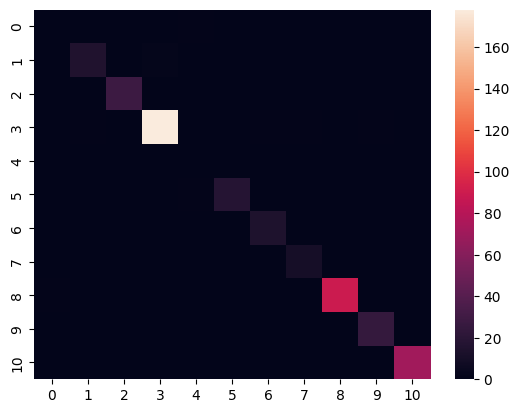

In [53]:
import seaborn as sns
sns.heatmap(cm)

## Style transfer

luego, para el clusteroide tomo esa imagen como referencia de estilo. y usos Quick Style Transfer traido desde https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization#specify_the_main_content_image_and_the_style_you_want_to_use

In [54]:
# tengo que poder buscar la imagen correspondiente al clusteroide
data = Z[:,:-1]

centroids = []
_labels = np.sort(list(set(labels)))
for nro_cluster in _labels:
    cluster_points = data[labels == nro_cluster]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)

In [55]:
from sklearn.metrics import pairwise_distances

clusteroids = []
for centroid in centroids:
    distances = pairwise_distances([centroid], data[labels != -1])
    closest_point_index = np.argmin(distances)
    clusteroid = data[labels != -1][closest_point_index]
    clusteroids.append(clusteroid)


In [56]:
# ahora quiero que en clusteroids sen vez de las coordenadas tenga el id correspondiente
# a[np.any(a == [4,5,6], axis = 1)]
#
ids.reset_index(inplace = True)


In [57]:
ids.iloc[0].loc['ids']

91250514

In [58]:

ids_clusteroides = []
for coordenadas_clusteroide in clusteroids:
    i = np.where(np.any(data == coordenadas_clusteroide, axis = 1))[0][0] #me encuentra el indice que contiene a este vector
    ids_clusteroides.append(ids.iloc[i].loc['ids'])


In [59]:
ids_clusteroides

[77402960,
 84025439,
 57305373,
 61089209,
 80896940,
 92536468,
 74860293,
 76145142,
 56981417,
 70219023,
 83778600]

In [60]:
clusteroides = {_labels[i]: ids_clusteroides[i] for i in range(len(clusteroids))}

In [61]:
clusteroides[-1] = -1

In [62]:
# ids.drop('_',axis = 1, inplace = True)
ids['cluster_id'] = pd.Series(labels)
ids['clusteroide_correspondiente'] = ids.cluster_id.map(lambda x: clusteroides.get(x))

In [63]:
clusteroide_por_cluster = ids.set_index('cluster_id')

In [64]:
# ahora lo que quiero hacer es cambiar el id del cluster por el indice, creo que puedo hacerlo con look up o sino con algo sobre esta lista mapeada
images_ids = list(map(lambda x: int(x[:-4]) ,images_ids))

In [65]:
ids['i_image_clusteroide_correspondiente'] = ids.loc[:,'clusteroide_correspondiente'].map(lambda x: images_ids.index(x) if x != -1 else np.nan)

In [66]:
i_imagen_por_cluster = ids.groupby('cluster_id').agg({'i_image_clusteroide_correspondiente': 'max'})

con esto entonces puedo para una nueva imagen, que me llegue, encontrar el cluster correcto

In [67]:
def obtener_estilo(tupla_de_atributos):
    # los atributos tiene que ser de la forma (ot, alias, setcode, type, atk, def, level, race, atribute, category)
    # la imagen tiene que ser a la que se le desea dar estilo de carta de yugioh

    if len(tupla_de_atributos) != 10:
        raise ValueError('cantidad incorrecta de parametros')
    x = np.array(tupla_de_atributos).reshape((1,-1))
    nro_cluster = model.predict(x)
    print(nro_cluster)
    indice_imagen = i_imagen_por_cluster.loc[nro_cluster,'i_image_clusteroide_correspondiente']
    img_estilo = images[i]
    return img_estilo

traigo Quick Style Transfer

### importar librerias y declarar funciones

In [68]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.12.0
TF Hub version:  0.13.0
Eager mode enabled:  True
GPU available:  []


In [69]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

# @functools.lru_cache(maxsize=None)
def custom_load_image(img, image_size=(256,256), preserve_aspect_ratio=True):
  img = tf.expand_dims(img, axis=0)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img / 255


def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


### aplicar mst

16220/16220 [==============================] - 0s 0us/step
[9.]


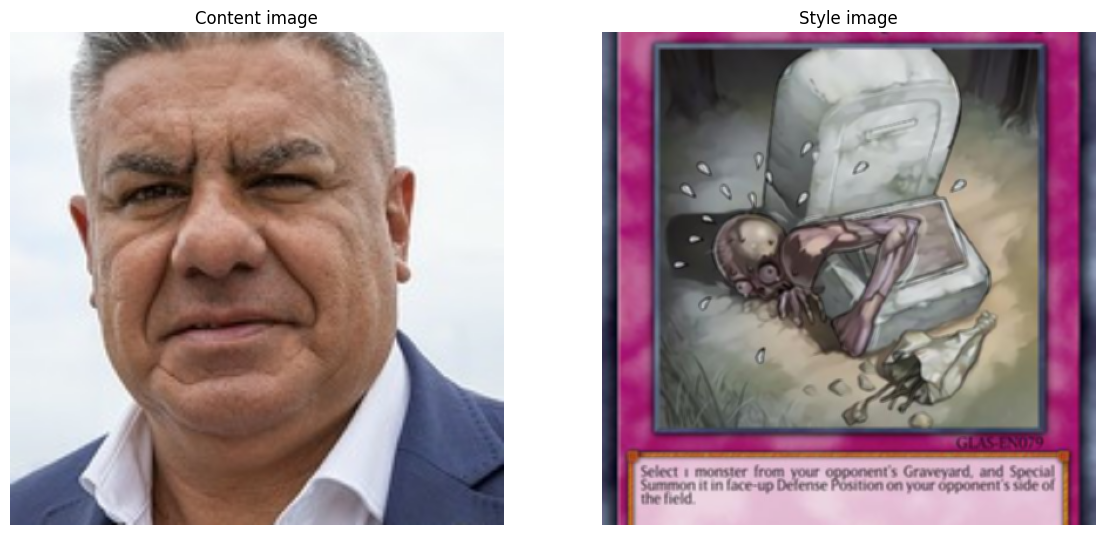

In [70]:
# @title ingresar url imagen contenido y los atributos separados por comas y sin espacios
content_img_size = (614, 421)
content_image_url = 'https://duckduckgo.com/i/13923f96.jpg'  # @param {type:"string"}
atributos = '3,0,0,131076, 0,0,0,0,0, 64'  # @param {type:"string"}

atributos = list(map(lambda x: int(x), atributos.split(',')))


content_image = load_image(content_image_url, content_img_size)

style_image = obtener_estilo(atributos)
style_image = custom_load_image(style_image, content_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])


## Import TF Hub module

In [71]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Demonstrate image stylization

In [72]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

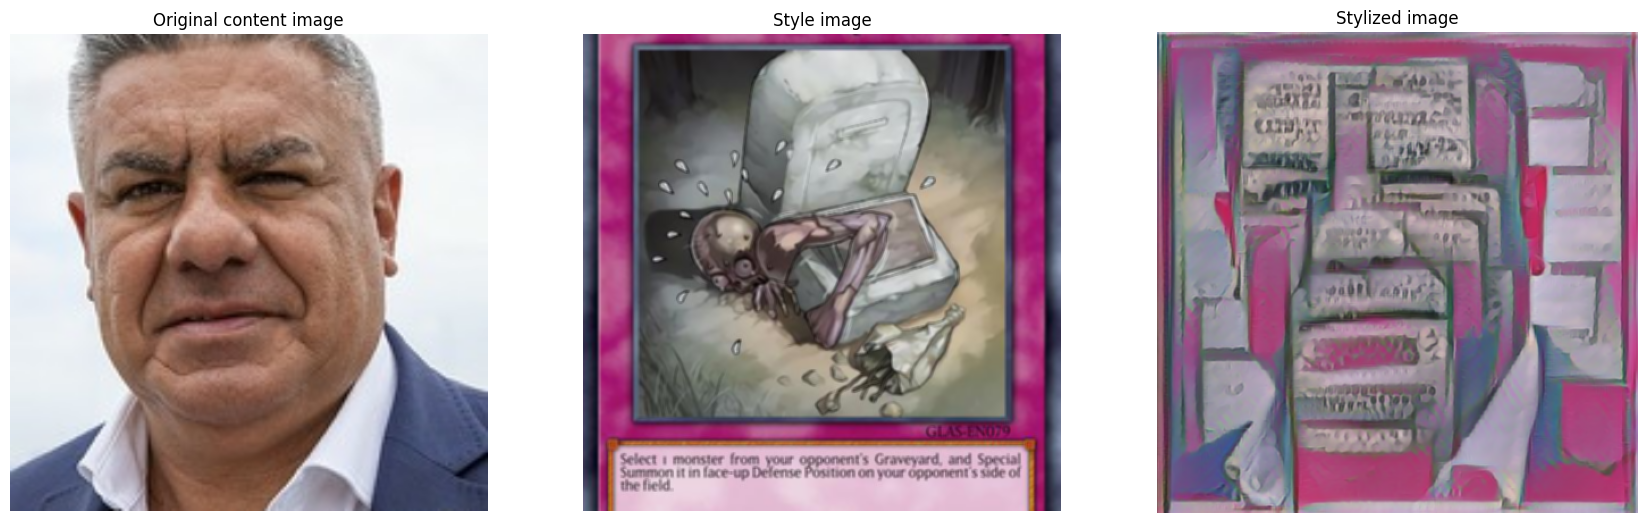

In [73]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])